### Гипотеза

Посмотреть влияет ли как то динамика изменения параметров чека. Как меняется сумма от чека к чеку, как изменяется количество позиций на каждый приход

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.prompt { min-width:10ex !important; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.float_format', lambda x: '%.6f' % x) 

/tmp/ipykernel_70592/437858164.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output
/tmp/ipykernel_70592/437858164.py:1: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, clear_output


In [3]:
df_train = pd.read_parquet('../data/train_dataset_hackaton2023_train.gzip')
df_test = pd.read_parquet('../data/hackaton2023_test.gzip')

In [4]:
ids_cols = ['customer_id', 'buy_post', 'startdatetime']

Схлопнуть до одного чека для каждого клиента

In [5]:
def create_dynamic_receipt_features(dataframe, ids_cols):
    df_sum_agg = dataframe.groupby(ids_cols, as_index=True).agg({"revenue": ["sum", "count"]})
    df_sum_agg.columns = ["revenue_sum", "items_count"]
    df_sum_agg.reset_index(inplace=True)
    df_sum_agg = df_sum_agg.sort_values(by=ids_cols)
    df_sum_agg["lag_sum"] = df_sum_agg.groupby(['customer_id'])['revenue_sum'].shift(1)
    df_sum_agg["lag_count"] = df_sum_agg.groupby(['customer_id'])['items_count'].shift(1)
    df_sum_agg["sum_delta"] = df_sum_agg["revenue_sum"] - df_sum_agg["lag_sum"]
    df_sum_agg["count_delta"] = df_sum_agg["items_count"] - df_sum_agg["lag_count"]
    new_ids_cols = list(set(ids_cols).difference(["startdatetime"]))
    df_by_customer_data = (
        df_sum_agg
        .groupby(new_ids_cols, as_index=False)
        .agg({
            "sum_delta": ["min", "max", "mean", "std"], 
            "count_delta": ["min", "max", "mean", "std"], 
        })
    )
    df_by_customer_data.columns = new_ids_cols + [
        f"{col}_{agg_func}" for col in ["sum_delta", "count_delta"]
        for agg_func in ["min", "max", "mean", "std"]
    ]
    df_by_customer_data["abs_sum_delta_mean"] = df_by_customer_data["sum_delta_mean"].abs()
    df_by_customer_data["abs_count_delta_mean"] = df_by_customer_data["count_delta_mean"].abs()
    return df_by_customer_data

In [6]:
df_train_processed = create_dynamic_receipt_features(df_train, ["customer_id", "buy_post", "startdatetime"])

In [7]:
df_train_processed.describe()

,customer_id,buy_post,sum_delta_min,sum_delta_max,sum_delta_mean,sum_delta_std,count_delta_min,count_delta_max,count_delta_mean,count_delta_std,abs_sum_delta_mean,abs_count_delta_mean
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,499991.000000,500000.000000,500000.000000,500000.000000,499991.000000,500000.000000,500000.000000
mean,20246346.095608,0.718190,-436.374135,389.744497,-22.598078,396.699632,-3.660972,3.344668,-0.159018,3.333694,105.327968,0.855371
std,11496610.350691,0.449882,434.825733,417.662915,175.282653,366.495636,3.421420,3.352346,1.378412,2.817907,141.917862,1.092541
min,29891.000000,0.000000,-18624.380000,-2994.850000,-6571.756667,0.000000,-186.000000,-13.000000,-62.000000,0.000000,0.000000,0.000000
25%,10731681.250000,0.000000,-602.950000,124.980000,-76.422857,160.146830,-5.000000,1.000000,-0.625000,1.414214,19.005000,0.142857
50%,21725643.000000,1.000000,-337.960000,298.990000,-6.996000,299.603651,-3.000000,3.000000,0.000000,2.774887,56.670000,0.500000
75%,28452387.000000,1.000000,-155.990000,549.980000,37.620312,520.247477,-1.000000,5.000000,0.333333,4.358899,136.663333,1.000000
max,46661804.000000,1.000000,2004.860000,22274.310000,7484.545000,14867.634252,15.000000,128.000000,42.500000,107.429046,7484.545000,62.000000


In [8]:
df_test_processed = create_dynamic_receipt_features(df_test, ["customer_id", "startdatetime"])

In [9]:
df_test_processed.describe()

,customer_id,sum_delta_min,sum_delta_max,sum_delta_mean,sum_delta_std,count_delta_min,count_delta_max,count_delta_mean,count_delta_std,abs_sum_delta_mean,abs_count_delta_mean
count,112334.000000,112334.000000,112334.000000,112334.000000,112332.000000,112334.000000,112334.000000,112334.000000,112332.000000,112334.000000,112334.000000
mean,20748611.321951,-428.073531,371.097107,-27.771253,401.142241,-3.543753,3.146892,-0.199400,3.325117,114.715882,0.913582
std,11582578.505840,431.264698,407.040922,187.817969,370.315073,3.370428,3.290386,1.447897,2.843575,151.284462,1.140845
min,52341.000000,-8094.100000,-1499.880000,-3228.860000,0.000000,-76.000000,-10.000000,-19.500000,0.000000,0.000000,0.000000
25%,11041231.250000,-594.987500,109.990000,-87.490000,156.929889,-5.000000,1.000000,-0.666667,1.414214,21.666667,0.166667
50%,22155898.000000,-328.980000,280.010000,-9.990000,300.499169,-3.000000,2.000000,0.000000,2.756810,63.008333,0.500000
75%,28861910.500000,-148.980000,529.980000,39.996667,527.474595,-1.000000,5.000000,0.400000,4.358899,149.495000,1.285714
max,46668221.000000,3080.050000,7104.100000,3307.460000,9201.941168,12.000000,89.000000,44.500000,62.932504,3307.460000,44.500000


### Analysis

In [79]:
df_train_processed.groupby(["buy_post"]).mean()

,customer_id,sum_delta_min,sum_delta_max,sum_delta_mean,sum_delta_std,count_delta_min,count_delta_max,count_delta_mean,count_delta_std,abs_sum_delta_mean,abs_count_delta_mean
buy_post,,,,,,,,,,,
0,21720533.623888,-406.661418,333.182100,-36.835281,412.228487,-3.251801,2.742394,-0.260571,3.322069,133.004185,1.042290
1,19667890.829808,-448.033084,411.938971,-17.011553,390.606366,-3.821526,3.580994,-0.119169,3.338256,94.468119,0.782026


In [80]:
df_train_processed.groupby(["buy_post"]).std()

,customer_id,sum_delta_min,sum_delta_max,sum_delta_mean,sum_delta_std,count_delta_min,count_delta_max,count_delta_mean,count_delta_std,abs_sum_delta_mean,abs_count_delta_mean
buy_post,,,,,,,,,,,
0,11696091.606157,440.849008,411.287825,207.068380,405.767897,3.274177,3.173673,1.576565,2.996827,162.923058,1.211231
1,11365283.446874,431.881897,418.053165,160.762379,349.696024,3.464321,3.390812,1.290206,2.744507,131.185693,1.033086


In [81]:
import plotly.io as pio

pio.renderers
pio.renderers.default = "png"

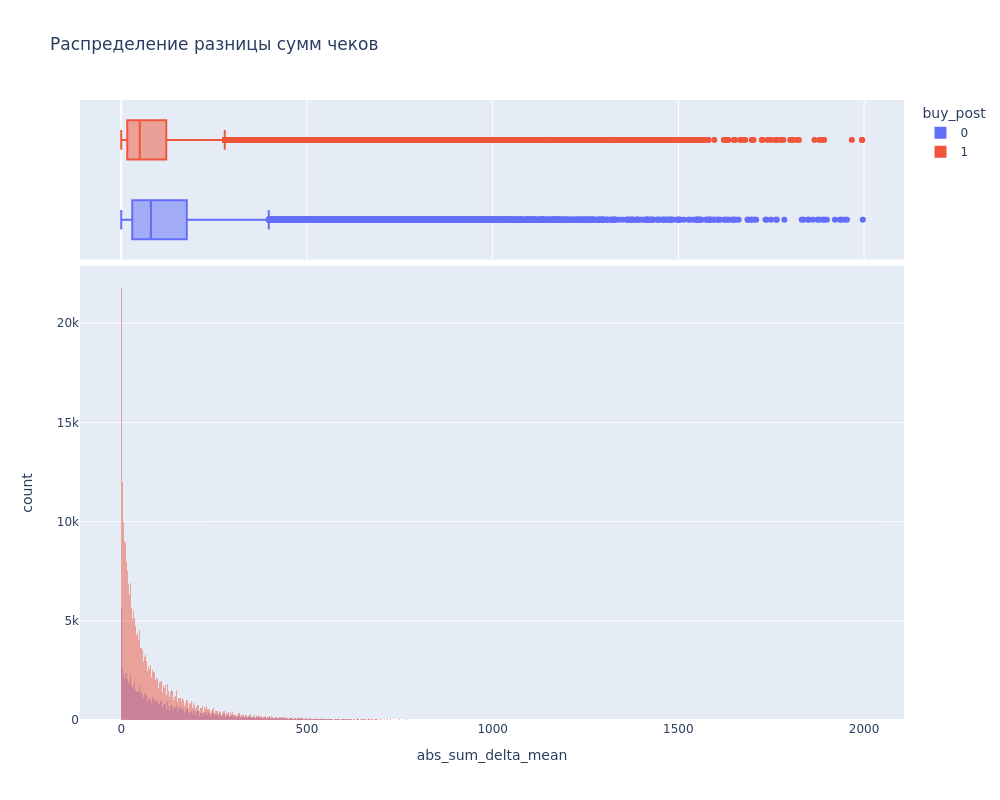

In [82]:
fig = px.histogram(
    df_train_processed[df_train_processed["abs_sum_delta_mean"] < 2000],
    x="abs_sum_delta_mean", 
    color="buy_post", 
    marginal="box",
    width=1000,
    height=800,
    title="Распределение разницы сумм чеков",
    barmode='overlay',
)
fig.show()

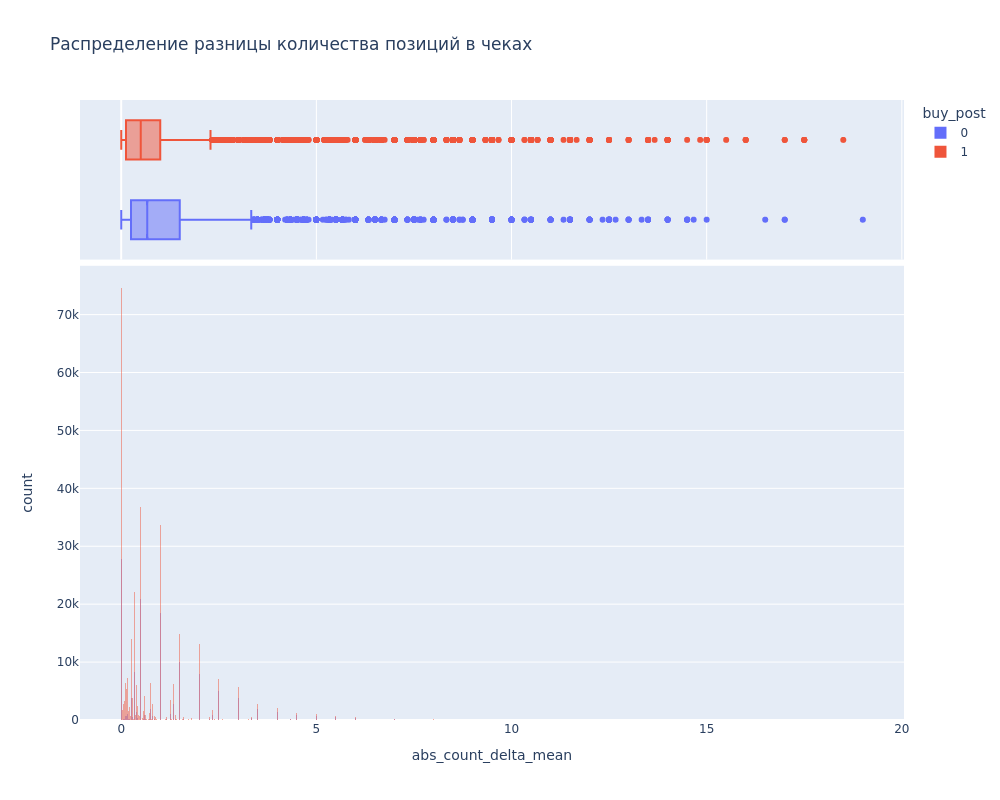

In [85]:
fig = px.histogram(
    df_train_processed[df_train_processed["abs_count_delta_mean"] < 20],
    x="abs_count_delta_mean", 
    color="buy_post", 
    marginal="box",
    width=1000,
    height=800,
    title="Распределение разницы количества позиций в чеках",
    barmode='overlay',
)
fig.show()

### Information value

IV < 0,02 — отсутствует;

0,02 ≤ IV <0,1 — низкая;

0,1 ≤ IV < 0,3 — средняя;

IV ≥ 0,3 — высокая.

In [32]:
def calculate_information_value(dataset, feats, target_col):
    iv_by_feat = {}
    temp = dataset.copy()
    for feat in feats:
        temp["quant_range"] = pd.qcut(
            x=temp[feat], q=[0, 0.25, 0.5, 0.75, 1.0], duplicates="drop"
        )

        bins = {}
        for i, bin in enumerate(temp["quant_range"].unique()):
            bins[bin] = i

        temp["bin"] = temp["quant_range"].apply(lambda x: bins[x])

        iv = (
            pd.crosstab(temp["bin"], temp[target_col], normalize="columns")
            .assign(woe=lambda dfx: np.log(dfx[1] / dfx[0]))
            .assign(iv=lambda dfx: np.sum(dfx["woe"] * (dfx[1] - dfx[0])))
        )["iv"].unique()[0]

        iv_by_feat[feat] = [iv]
    df = pd.DataFrame(iv_by_feat).T
    df.reset_index(inplace=True)
    df.columns = ["feature", "IV"]
    return df

In [33]:
feats = [
    "sum_delta_min",
    "sum_delta_max",
    "sum_delta_mean",
    "sum_delta_std",
    "count_delta_min",
    "count_delta_max",
    "count_delta_mean",
    "count_delta_std",
    "abs_sum_delta_mean",
    "abs_count_delta_mean",
]

In [34]:
iv_df = calculate_information_value(df_train_processed, feats, "buy_post")

In [37]:
iv_df.sort_values(by="IV", ascending=False)

,feature,IV
8,abs_sum_delta_mean,0.097432
2,sum_delta_mean,0.081003
5,count_delta_max,0.078453
6,count_delta_mean,0.077059
1,sum_delta_max,0.065213
9,abs_count_delta_mean,0.052973
4,count_delta_min,0.037541
7,count_delta_std,0.024725
0,sum_delta_min,0.021761
3,sum_delta_std,0.013450
